# 在OpenCL兼容的GPU上进行对象分割
APOC基于[pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype)和[scikit-learn](https://scikit-learn.org/stable/)。对于对象分割，它使用像素分类器和连通组件标记。

让我们从加载示例图像和一些真实标注开始：

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc

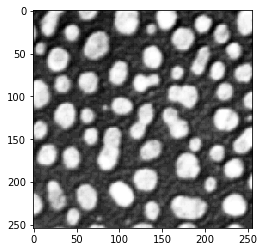

In [2]:
image = imread('../../data/blobs.tif')
cle.imshow(image)

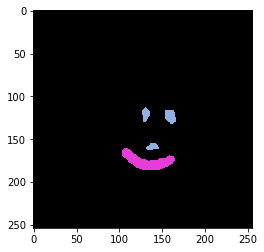

In [3]:
manual_annotations = imread('../../data/blobs_annotations.tif')

cle.imshow(manual_annotations, labels=True)

## 训练
我们现在训练一个ObjectSegmenter，它在底层是一个[scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)。训练后，分类器将被转换为[clij兼容的OpenCL代码](https://github.com/clEsperanto/clij-opencl-kernels)并保存到指定的文件名下的磁盘上。

In [4]:
# define features
features = apoc.PredefinedFeatureSet.medium_quick.value

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter.cl'

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, image)

## 预测 / 分割
然后可以使用分类器对给定图像中的所有像素进行分类。起点仍然是特征堆栈。因此，用户必须确保在训练和预测时使用相同的特征。预测可以在CPU上使用原始的scikit-learn代码进行，也可以在GPU上使用生成的OpenCL代码进行。如果两个结果图像看起来相同，那么OCLRFC工作良好。

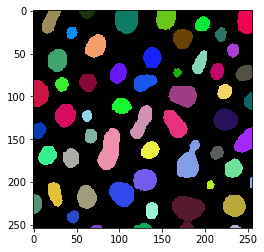

In [5]:
segmentation_result = clf.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

## 从加载的分割器进行分割

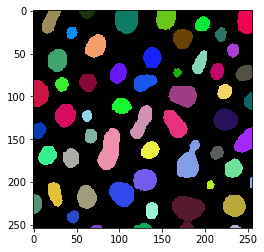

In [6]:
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename)

segmentation_result = clf.predict(image=image)
cle.imshow(segmentation_result, labels=True)